<a href="https://colab.research.google.com/github/three0-s/PRML/blob/main/Ch6.%20Kernel%20Methods/house_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**House Prices- kaggle contest**

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [9]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from collections import Counter

train_df = pd.read_csv("/content/gdrive/MyDrive/Kaggle/House Prices/train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/Kaggle/House Prices/test.csv")

num_features = train_df.dtypes[train_df.dtypes != 'object'].index
categorical_features = train_df.dtypes[train_df.dtypes == 'object'].index

for feature in categorical_features:
  for index, category in enumerate(train_df[feature].unique()):
    train_df[feature].replace(to_replace=category, value=index, inplace=True)
    test_df[feature].replace(to_replace=category, value=index, inplace=True)

train_df.fillna(train_df.mean(), inplace=True)
test_df.fillna(test_df.mean(), inplace=True)

drop_index = []

X_train = train_df.drop(drop_index, axis=0).reset_index(drop=True)
Y_train = X_train['SalePrice']

X_train.drop(labels=['Id', 'SalePrice'], axis=1, inplace=True)
X_test = test_df.drop(labels='Id', axis=1, inplace=False)

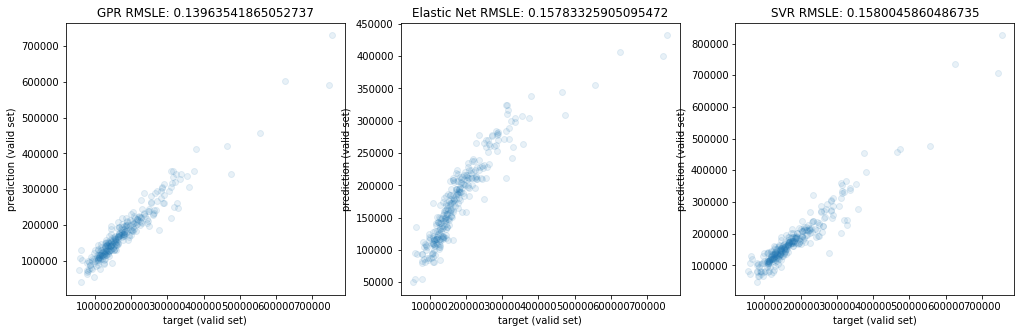

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import mean_squared_log_error

pipeline = Pipeline([
            ('std_scaler', StandardScaler())
])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)

X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 2000)

kernel = 3*DotProduct()**3 + 2*DotProduct()**2 + WhiteKernel()
gpr = GaussianProcessRegressor(n_restarts_optimizer=10, kernel=kernel, alpha=0.1)
gpr.fit(X_tr, y_tr)

elenet_reg = ElasticNet(l1_ratio=0.5)
elenet_reg.fit(X_tr, y_tr)

svr = SVR(epsilon=0.09, C=0.5, kernel=kernel)
svr.fit(X_tr, y_tr)

y_pred = gpr.predict(X_vld)
RMSE = mean_squared_log_error(y_vld, abs(y_pred))**0.5

fig = plt.figure(figsize=(17, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_vld, y_pred, alpha=0.1)
plt.xlabel("target (valid set)")
plt.ylabel("prediction (valid set)")
plt.title("GPR RMSLE: {err}".format(err=RMSE))

ele_y_pred = elenet_reg.predict(X_vld)
RMSE_2 = mean_squared_log_error(y_vld, abs(ele_y_pred))**0.5

plt.subplot(1, 3, 2)
plt.scatter(y_vld, ele_y_pred, alpha=0.1)
plt.xlabel("target (valid set)")
plt.ylabel("prediction (valid set)")
plt.title("Elastic Net RMSLE: {err}".format(err=RMSE_2))

svm_y_pred = svr.predict(X_vld)
RMSE_3 = mean_squared_log_error(y_vld, abs(svm_y_pred))**0.5

plt.subplot(1, 3, 3)
plt.scatter(y_vld, svm_y_pred, alpha=0.1)
plt.xlabel("target (valid set)")
plt.ylabel("prediction (valid set)")
plt.title("SVR RMSLE: {err}".format(err=RMSE_3))


plt.show()

Text(0.5, 1.0, 'Blending Model(GP + ElasticNet + SVM) RMSLE: 0.132')

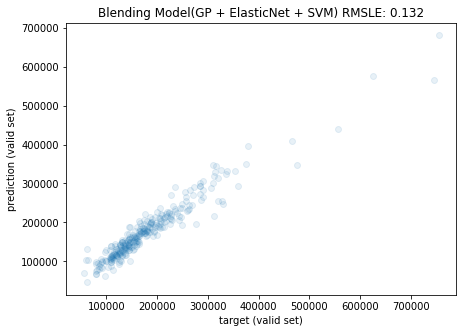

In [15]:
gpr_weight = 1 - RMSE / (RMSE + RMSE_2 + RMSE_3)
ele_weight = 2*(1 - gpr_weight)/3
svr_weight = (1 - gpr_weight)/3
  
def predict(X):
  
  return gpr.predict(X)*gpr_weight + elenet_reg.predict(X) * ele_weight + svr.predict(X) * svr_weight 

y_pred = predict(X_vld)
RMSE = mean_squared_log_error(y_vld, abs(y_pred))**0.5

fig = plt.figure(figsize=(7, 5))
plt.scatter(y_vld, y_pred, alpha=0.1)
plt.xlabel("target (valid set)")
plt.ylabel("prediction (valid set)")
plt.title("Blending Model(GP + ElasticNet + SVM) RMSLE: {err:0.3f}".format(err=RMSE))

In [16]:
print(gpr_weight, svr_weight, ele_weight)

0.7042420226778257 0.09858599244072479 0.19717198488144957


In [17]:
import pandas as pd
result = pd.DataFrame()

y_test = predict(X_test)
result['Id'] = test_df['Id']
result['SalePrice'] = abs(y_test)

result.to_csv(r"/content/gdrive/MyDrive/Kaggle/House Prices/result.csv", index=False)